## Compare yeast and human paralog family sizes

Use Cerevisiae paralogs from Ensembl

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator

%load_ext autoreload
%autoreload 1
%aimport graphing_params

get_data_path = lambda folders, fname: os.path.normpath(os.environ['3RD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+ fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

file_yeast_paralogs = get_data_path(['ensembl', '93'], 'cerevisiae_paralogs.txt')
file_human_pairs = get_local_data_path(['processed','ensembl93'], 'all_pairs.csv')

### Yeast paralog families

In [2]:
raw_data = pd.read_csv(file_yeast_paralogs)

In [3]:
raw_data[:1]

,Gene stable ID,Saccharomyces cerevisiae paralogue gene stable ID,Paralogue %id. target Saccharomyces cerevisiae gene identical to query gene,Paralogue %id. query gene identical to target Saccharomyces cerevisiae gene
0,YHR055C,YHR053C,100.0,100.0


In [5]:
data = raw_data.rename(columns={
    'Gene stable ID': 'A1_gene_id',
    'Saccharomyces cerevisiae paralogue gene stable ID': 'A2_gene_id',
    'Paralogue %id. target Saccharomyces cerevisiae gene identical to query gene': 'sequence_identity',
    'Paralogue %id. query gene identical to target Saccharomyces cerevisiae gene': 'sequence_identity_reverse'})
# Drop A2 genes that do not appear in A1 column (these would be non-protein coding)
# Data should be symmetric
all_yeast_paralog_pairs = data[data.A2_gene_id.isin(data.A1_gene_id)].reset_index(drop=True)
print('N pairs:', all_yeast_paralog_pairs.shape[0])
all_yeast_paralog_pairs[:1]

N pairs: 11898


,A1_gene_id,A2_gene_id,sequence_identity,sequence_identity_reverse
0,YHR055C,YHR053C,100.0,100.0


In [6]:
# Restrict to min. 20% sequence identity (either direction)
yeast_paralog_pairs = all_yeast_paralog_pairs[(all_yeast_paralog_pairs.sequence_identity >= 20) | 
                                              (all_yeast_paralog_pairs.sequence_identity_reverse >= 20)]
print('N yeast paralog pairs (min. 20% seq id):', yeast_paralog_pairs.shape[0])

N yeast paralog pairs (min. 20% seq id): 10838


In [7]:
def compute_family_sizes(paralog_pairs, A1_id, A2_id):
    # Set of all paralogs for each A1
    paralog_families = paralog_pairs.groupby(A1_id).agg({A2_id:set}).reset_index()
    paralog_families = paralog_families.rename(columns={A1_id:'gene', A2_id:'paralogs'})
    display(paralog_families[:1])

    # Family = union of all A1 and all A2 paralogs
    df = pd.merge(paralog_pairs[[A1_id,A2_id]], paralog_families.rename(columns={'gene':A1_id}))
    df = pd.merge(df, paralog_families.rename(columns={'gene':A2_id}), on=[A2_id])
    df['family'] = df.apply(lambda x: x.paralogs_x.union(x.paralogs_y), axis=1)
    
    # Turn each family into a frozenset to compute the number of unique sets (families)
    unique_families = set(df.family.apply(lambda x: frozenset(x)).values)
    return unique_families

In [8]:
unique_yeast_families = compute_family_sizes(yeast_paralog_pairs, 'A1_gene_id', 'A2_gene_id')
print('N unique families:', len(unique_yeast_families))
yeast_family_sizes = [len(x) for x in unique_yeast_families]

,gene,paralogs
0,Q0050,"{Q0060, Q0070, Q0055, Q0065}"


N unique families: 726


### Human paralog families

In [10]:
all_human_paralogs = pd.read_csv(file_human_pairs)
human_paralogs = all_human_paralogs[all_human_paralogs.max_seq_id >= 0.2].reset_index(drop=True)
print('N human paralog pairs:', human_paralogs.shape[0])
human_paralogs[:1]

N human paralog pairs: 73296


,A1_ensembl,A2_ensembl,sequence_identity,min_seq_id,max_seq_id,singh_wgd,makino_wgd,WGD,same_chr,closest,family_size,cds_length_ratio,A1,A1_entrez,A2,A2_entrez
0,ENSG00000092850,ENSG00000163060,0.293023,0.289655,0.293023,False,True,True,False,False,5,0.988532,TEKT2,27285,TEKT4,150483


In [11]:
unique_human_families = compute_family_sizes(human_paralogs, 'A1_ensembl', 'A2_ensembl')
print('N unique families:', len(unique_human_families))
human_family_sizes = [len(x) for x in unique_human_families]

,gene,paralogs
0,ENSG00000000003,"{ENSG00000048140, ENSG00000135404, ENSG0000015..."


N unique families: 4341


### Compare family sizes

In [13]:
family_sizes = pd.concat([pd.DataFrame({'fam_size':human_family_sizes, 'species':'Human'}),
                          pd.DataFrame({'fam_size':yeast_family_sizes, 'species':'Yeast'})])
print('Median yeast family size:', family_sizes[family_sizes.species=='Yeast'].fam_size.median())
print('Mean yeast family size:', family_sizes[family_sizes.species=='Yeast'].fam_size.mean())
print('Median human family size:', family_sizes[family_sizes.species=='Human'].fam_size.median())
print('Mean human family size:', family_sizes[family_sizes.species=='Human'].fam_size.mean())
family_sizes[:1]

Median yeast family size: 2.0
Mean yeast family size: 3.760330578512397
Median human family size: 4.0
Mean human family size: 5.167472932504031


,fam_size,species
0,2,Human


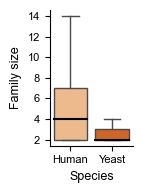

In [27]:
f, ax = plt.subplots(1, 1, figsize=(1.5,2))
sns.boxplot(data=family_sizes, y='fam_size', x='species', ax=ax, showfliers=False, linewidth=1, 
            palette=sns.color_palette('Oranges',2), medianprops=dict(linewidth=1.5, color='black'))
ax.set_xlabel('Species')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('Family size')
plt.tight_layout()